#  Object detection

## 1. Import packages.

In [1]:
# colab: 런타임 -> 런타임 유형변경 -> GPU

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT" -O VOC2007.zip && rm -rf ~/cookies.txt

import zipfile
with zipfile.ZipFile('VOC2007.zip', 'r')as f:
    f.extractall('./')

!rm -rf VOC2007.zip
!rm -rf __MACOSX

--2023-06-27 14:14:12--  https://docs.google.com/uc?export=download&confirm=t&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT
Resolving docs.google.com (docs.google.com)... 142.251.12.101, 142.251.12.139, 142.251.12.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/48p7n50gn2g8egn1sjkusqvt4f5br58v/1687875225000/16525786242263481678/*/1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT?e=download&uuid=5ab18b14-d968-410c-8b4d-77c157ed3cd7 [following]
--2023-06-27 14:14:12--  https://doc-04-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/48p7n50gn2g8egn1sjkusqvt4f5br58v/1687875225000/16525786242263481678/*/1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT?e=download&uuid=5ab18b14-d968-410c-8b4d-77c157ed3cd7
Resolving doc-04-1k-docs.googleusercontent.com (doc-04-1k-docs.googleusercontent.com)... 74.125.200.132, 

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os
import random
import math
import numpy as np
from collections import OrderedDict
import xml.etree.ElementTree as ET

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision.ops import misc as misc_nn_ops

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Funtion for visualization
def draw_bb(img, boxes, color='r', figsize=(8,8)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

### Fuction for vislualize boudning with two differnt colors
def draw_bb2(img, boxes1, boxes2, color1='r', color2='g', figsize=(20,20)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes1:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
    for box in boxes2:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color2,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

## 2. Define Pascal VOC dataloader.

- Pascal VOC dataset folder structure

data/VOC2007/  

>ImageSets/Main/  
>>train.txt  
>>train_small.txt(optional)  

>JPEGImages/  
>>000005.jpg  
>>000007.jpg  
>>000009.jpg  
>>000012.jpg  
>>...  

>Annotations/  
>>000005.xml  
>>000007.xml  
>>000009.xml  
>>000012.xml  
>>...  

- PASCAL VOC image example :

![PASCAL VOC SAMPLE IMAGE](./VOC2007/JPEGImages/000010.jpg)

### 2-1. Recap of the dataloader we define

In [4]:
class PascalDataset(data.Dataset):
    def __init__(self, voc_root, image_set, transforms):
        ### Data root, transform
        self.data_root = voc_root
        self.transforms = transforms

        ### class name to class label mapping
        self._classes = ('__background__',
                         'aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
        self._class_to_ind = dict(zip(self._classes, range(len(self._classes))))


        ### Load image list
        self.img_list = []
        splits_dir = os.path.join(voc_root, 'ImageSets/Main')## splits_dir = 'voc_root/ImageSets/Main'
        split_f = os.path.join(splits_dir, image_set + '.txt')## split_f = voc_root/ImageSets/Main/train.txt(or trainval.txt or val.txt)
        self._load_img_name_list(split_f)

    def _load_img_name_list(self, img_list_path):
        with open(img_list_path) as f:
            self.img_list = f.read().splitlines()

    def _load_annotation(self, index, img_path):
        filename = os.path.join(self.data_root, 'Annotations', img_path + '.xml') ## file_name = 'self.data_root/Annotations/image_path.xml'
        tree = ET.parse(filename)
        objs = tree.findall('object')
        num_objs = len(objs)

        boxes = np.zeros((num_objs, 4), dtype=np.float32)
        gt_classes = np.zeros((num_objs, ), dtype=np.int64)

        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')

            # Make pixel indexes 0-based
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1

            cls = self._class_to_ind[obj.find('name').text.lower().strip()]
            boxes[ix, :] = [x1, y1, x2, y2]
            gt_classes[ix] = cls

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {}

        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32) ## Bounding Box Annotation을 텐서로 만듬
        target["labels"] = torch.as_tensor(gt_classes, dtype=torch.int64) ## Class Label을 텐서로 만듬

        target["image_id"] = torch.tensor([index]) ## 이미지 아이디
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) ## (ymax-ymin)*(xmax-xmin) = w*h

        # no crowd
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)

        return target

    def __len__(self,):## Essential Function in Custom Dataset
        return len(self.img_list)

    def __getitem__(self, index):## Essential Function in Custom Datset
        ### Load images
        img_path = self.img_list[index]
        img = Image.open(os.path.join(self.data_root,'JPEGImages',img_path + '.jpg')).convert("RGB")

        ### Load label dictionary
        target = self._load_annotation(index, img_path)

        ### Transform
        if self.transforms is not None:
            img, target = self.transforms(img), target
        return img, target

### 2-2. Visualize a sample.

torch.Size([3, 333, 500]) 
 {'boxes': tensor([[155.,  96., 350., 269.]]), 'labels': tensor([7]), 'image_id': tensor([0]), 'area': tensor([33735.]), 'iscrowd': tensor([0])}


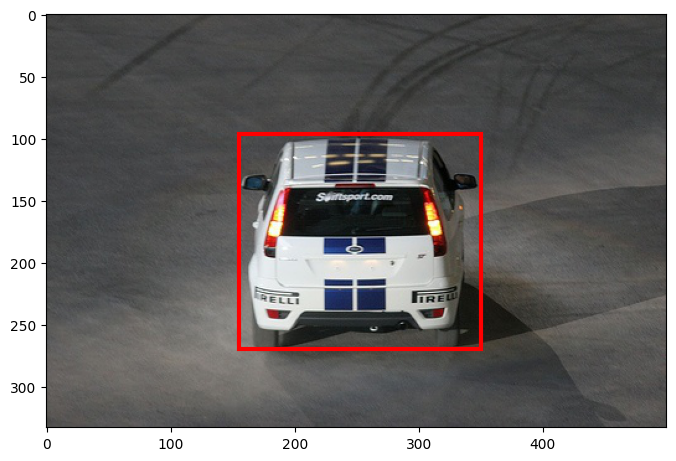

In [5]:
from torchvision import transforms

transfroms = transforms.Compose([
    transforms.ToTensor()
])

voc_data = PascalDataset(voc_root='./VOC2007/', image_set='train', transforms=transfroms)
voc_iter = iter(voc_data)
img, label = next(voc_iter)

print(img.shape, '\n', label)

img_PIL = transforms.ToPILImage()(img.clone())
bb_label = label['boxes']
draw_bb(img=img_PIL, boxes=bb_label)

## 3. Define Faster-RCNN.

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# doc: https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html

# load a model pre-trained pre-trained on COCO train 2017, COCO는 class 91개
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 21  #  class (20) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 125MB/s]


In [7]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [8]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 15, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 60, kernel_size=(1, 1), stride=(1, 1))
  )
)

## 4. Fine-tune Faster-RCNN.

In [42]:
transfroms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalization value
])

# train on the GPU or on the CPU, if a GPU is not available
voc_train = PascalDataset(voc_root='./VOC2007/', image_set='train', transforms=transfroms)
voc_test = PascalDataset(voc_root='./VOC2007/', image_set='val', transforms=transfroms)


def collate_fn(batch):
    zip_batch = zip(*batch)
    tuple_batch = tuple(zip_batch)
    return tuple_batch


### define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    voc_train, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    voc_test, batch_size=16, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# move model to device
model = model.to(device)

# construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# let's train it for 1 epochs
num_epochs = 10
# print loss every 10 mini-batches
print_step = 10

# train for one epoch, printing every 10 iterations
for epoch in range(num_epochs):
    ## enumerate through data_loader
    ### Train mode
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader_train):

        ### Load input data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        ### Forward & loss aggregation
        loss_dict = model(images, targets)

        ### 로스 종류 확인
        ### print(loss_dict.keys())

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        ### BackPropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        ### print itermedicate outputs
        if(batch_idx % print_step == 0):
            print('Epoch: [{}/{}], Iterations: [{}/{}], loss: {}  '.format(epoch, num_epochs, batch_idx, len(data_loader_train), loss_value))

print('Training Done!')

Epoch: [0/10], Iterations: [0/157], loss: 3.676591396331787  
Epoch: [0/10], Iterations: [10/157], loss: 1.9198968410491943  
Epoch: [0/10], Iterations: [20/157], loss: 1.2985423803329468  
Epoch: [0/10], Iterations: [30/157], loss: 1.1785355806350708  
Epoch: [0/10], Iterations: [40/157], loss: 0.9795164465904236  
Epoch: [0/10], Iterations: [50/157], loss: 0.7579351663589478  
Epoch: [0/10], Iterations: [60/157], loss: 0.6555386781692505  
Epoch: [0/10], Iterations: [70/157], loss: 0.9060111045837402  
Epoch: [0/10], Iterations: [80/157], loss: 0.8523929715156555  
Epoch: [0/10], Iterations: [90/157], loss: 0.6754345297813416  
Epoch: [0/10], Iterations: [100/157], loss: 0.7131462097167969  
Epoch: [0/10], Iterations: [110/157], loss: 0.8181062340736389  
Epoch: [0/10], Iterations: [120/157], loss: 0.7519192099571228  
Epoch: [0/10], Iterations: [130/157], loss: 0.9704052209854126  
Epoch: [0/10], Iterations: [140/157], loss: 1.0731068849563599  
Epoch: [0/10], Iterations: [150/157],

In [16]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 344861, done.
remote: Counting objects: 100% (61093/61093), done.
remote: Compressing objects: 100% (1622/1622), done.
remote: Total 344861 (delta 60066), reused 60326 (delta 59427), pack-reused 283768
Receiving objects: 100% (344861/344861), 690.79 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (317917/317917), done.


In [40]:
%cd /content/vision/references/detection

/content/vision/references/detection
coco_eval.py   engine.py		 presets.py   README.md  transforms.py
coco_utils.py  group_by_aspect_ratio.py  __pycache__  train.py	 utils.py


In [43]:
# predefined evaluation function

from engine import evaluate
#egg=pycocotools^&subdirectory=PythonAPI.
voc_test = PascalDataset(voc_root='/content/VOC2007/', image_set='val', transforms=transfroms)
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/157]  eta: 0:03:36  model_time: 0.2903 (0.2903)  evaluator_time: 0.1087 (0.1087)  time: 1.3776  data: 0.9524  max mem: 2807
Test:  [100/157]  eta: 0:00:15  model_time: 0.1337 (0.1435)  evaluator_time: 0.0469 (0.0570)  time: 0.2452  data: 0.0469  max mem: 2807
Test:  [156/157]  eta: 0:00:00  model_time: 0.1210 (0.1414)  evaluator_time: 0.0394 (0.0562)  time: 0.2210  data: 0.0458  max mem: 2807
Test: Total time: 0:00:42 (0.2736 s / it)
Averaged stats: model_time: 0.1210 (0.1414)  evaluator_time: 0.0394 (0.0562)
Accumulating evaluation results...
DONE (t=3.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=med

## 5. Visulize the evaluation results.

In [44]:
# eval mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [45]:
data_it = iter(data_loader_test)

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

tensor([0.4232, 0.2147, 0.2068, 0.1653, 0.1550, 0.1506, 0.1485, 0.1461, 0.1368,
        0.1338, 0.1199, 0.1187, 0.1176, 0.1165, 0.1076, 0.1067, 0.1048, 0.0957,
        0.0898, 0.0840, 0.0825, 0.0807, 0.0789, 0.0720, 0.0711, 0.0690, 0.0676,
        0.0667, 0.0663, 0.0628, 0.0624, 0.0620, 0.0586, 0.0582, 0.0572, 0.0572,
        0.0570, 0.0564, 0.0563, 0.0544], device='cuda:0',
       grad_fn=<IndexBackward0>)
0


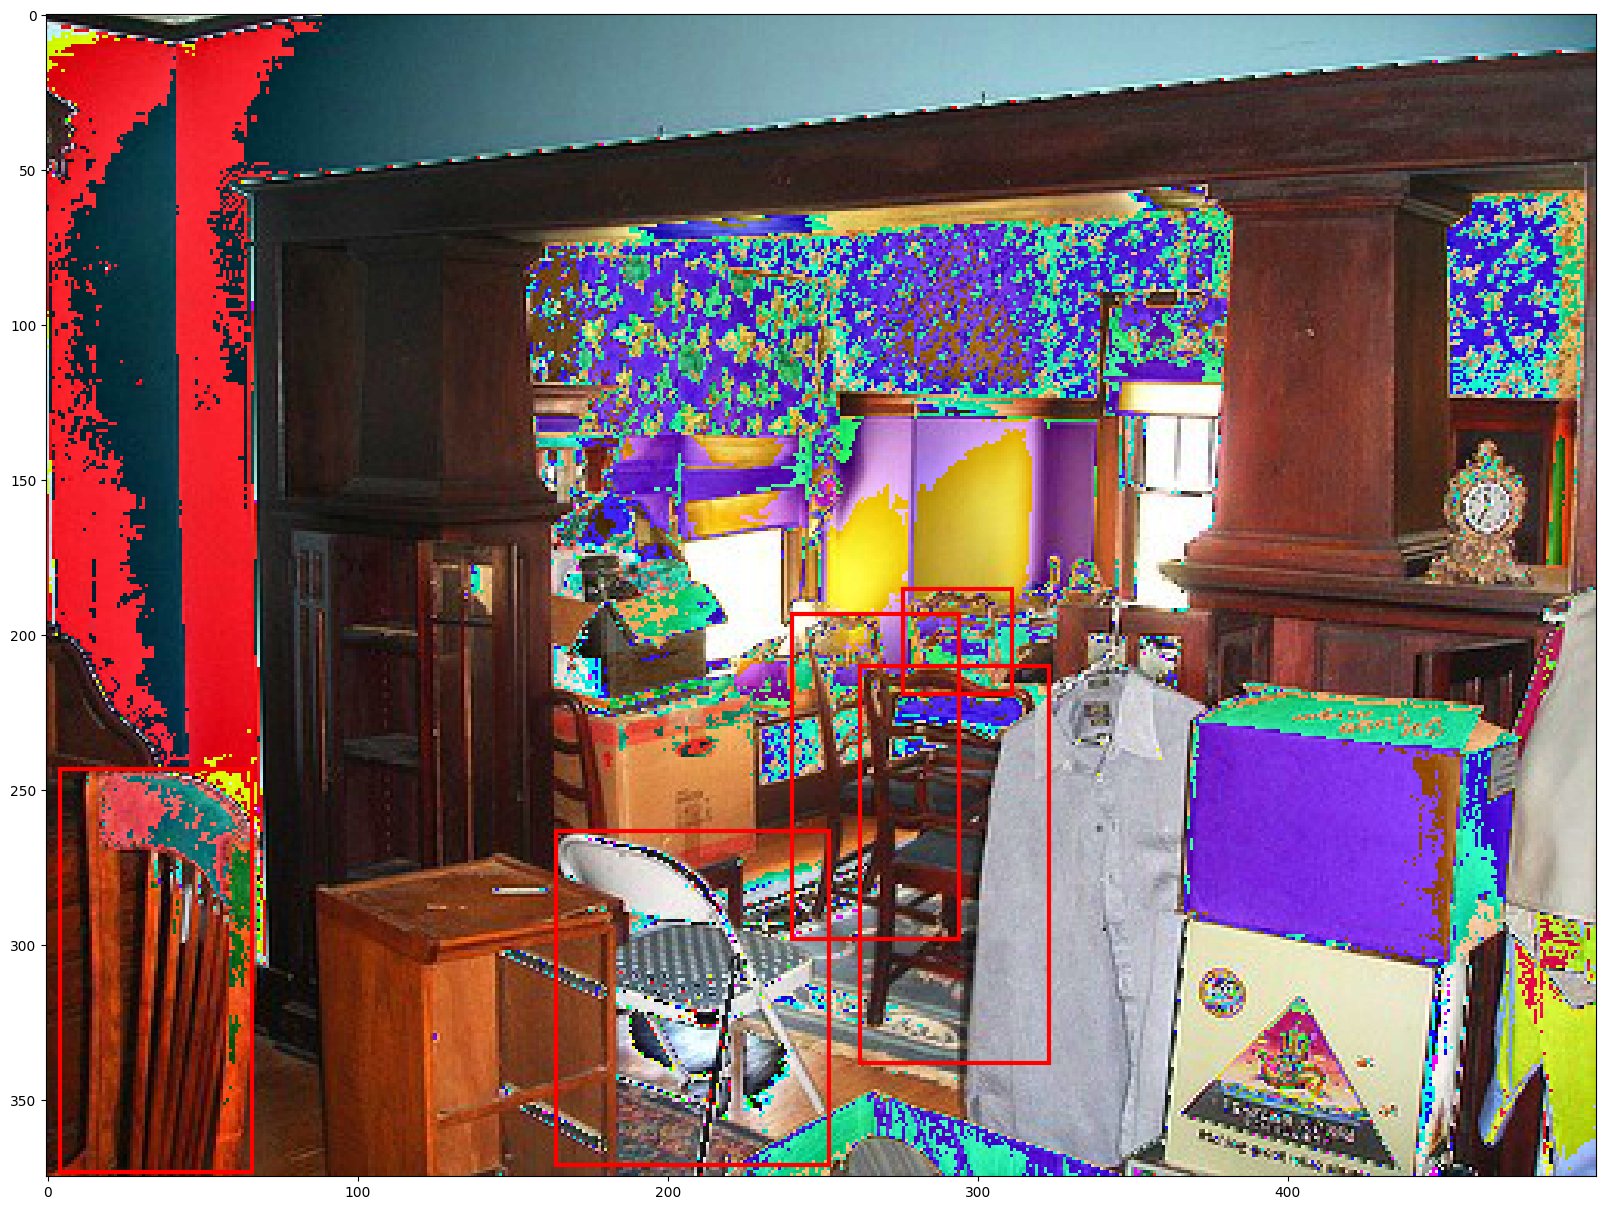

tensor([15, 15, 15, 11,  9,  9, 15, 11, 18, 11,  9,  9,  9, 11,  9,  9,  9,  9,
         9,  9,  9,  9, 11,  9,  9, 15, 14, 11, 11, 18,  5, 15, 11,  9, 18, 18,
         9,  2,  9,  9], device='cuda:0')


In [46]:
imgs, labels = next(data_it)

img_test = imgs[0]
bbox_test = labels[0]['boxes']

prediction = model(list([img_test.to(device)]))
scores = prediction[0]['scores']
print(scores)
threshold = (scores>0.8).sum().cpu().detach().item()
print(threshold)
### transform for visulization
P = torchvision.transforms.ToPILImage()
img_test_PIL = P(img_test)
prediction_bbox_np = prediction[0]['boxes'].cpu().detach().numpy()[:threshold]
draw_bb2(img_test_PIL, bbox_test, prediction_bbox_np)
print(prediction[0]['labels'])

## (Optional) Test on an image you want.

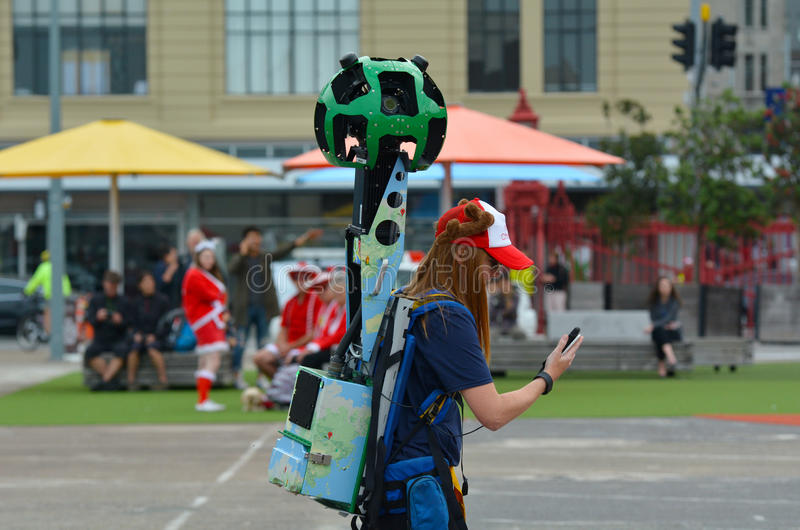

In [52]:
# read image
img_demo = Image.open('/content/sample.jpg').convert("RGB")
img_demo

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

tensor([0.2184, 0.1828, 0.1466, 0.1403], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([15, 13, 12, 14], device='cuda:0')
[[263.4778   62.97341 567.97    507.9086 ]
 [250.32835 158.67001 590.48016 519.6625 ]
 [227.83418 161.06306 548.42883 522.33307]
 [209.51912 137.39188 598.8     514.4849 ]]


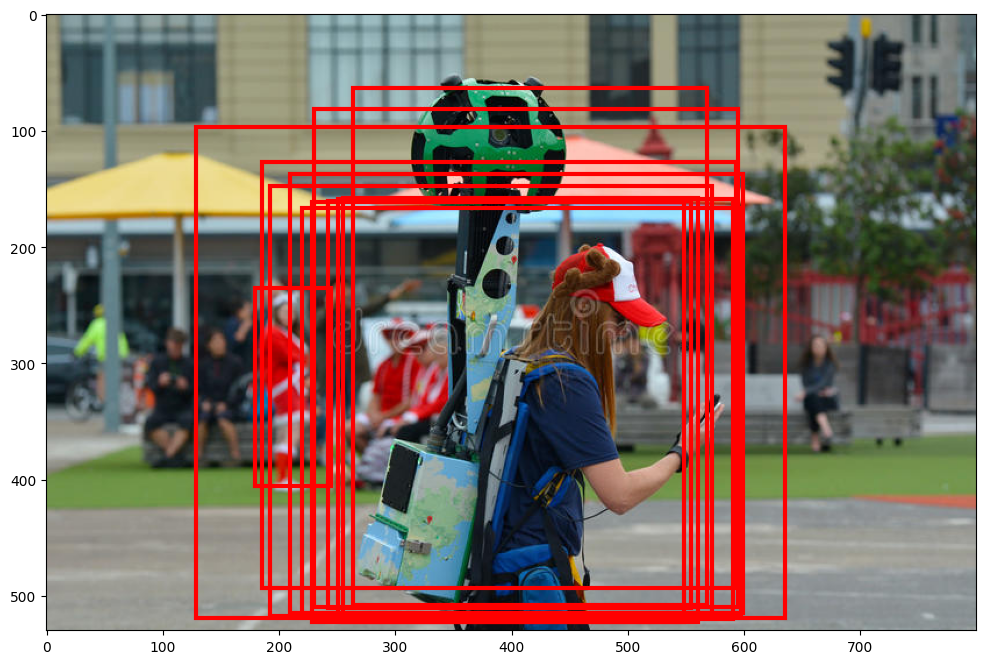

In [63]:
# Forward through trained model
bboxes_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['boxes']
scores_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['scores']
labels_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['labels']
bboxes_demo_np = bboxes_demo.cpu().detach().numpy()

threshold = (scores_demo>0.1).sum().cpu().detach().item()

print(scores_demo[:threshold])
print(labels_demo[:threshold])
print(bboxes_demo_np[:threshold])

# Draw bounding boxes
draw_bb(img_demo, bboxes_demo_np, 'r', (12, 12))